# Intro Task, Object Localization

In [31]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [32]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [33]:
import pandas as pd

# File paths
CSV_FILE = '/home/tom/Python/Machine learning/pytorch/object-localization-dataset/train.csv'
DATA_DIR = '/home/tom/Python/Machine learning/pytorch/object-localization-dataset/'

# Device settings
DEVICE = 'cuda'

# Model parameters
BATCH_SIZE = 16
IMG_SIZE = 140
LR = 0.001
EPOCHS = 40

# Other constants
NUM_COR = 4


In [34]:
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


In [35]:
df.label.unique()

#therefore 3 classes
# so total output dimension in fully connectedlayer layer is 3+1 (1 is for bindingbox)

array(['mushroom', 'eggplant', 'cucumber'], dtype=object)

In [36]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Augmentations

In [37]:
import albumentations as A

In [38]:
#This function is to apply transformations to the image aswell as bindingbox in the same way
IMG_SIZE = 224  

train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

valid_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

# Create Custom Dataset

In [39]:
class ObjLocDataset(torch.utils.data.Dataset):
    def __init__(self, df, augmentations=None):
        self.df = df
        self.augmentations = augmentations
        self.label_map = {"mushroom": 0, "eggplant": 1, "cucumber": 2}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        xmin = row.xmin
        ymin = row.ymin
        xmax = row.xmax
        ymax = row.ymax

        bbox = [[xmin, ymin, xmax, ymax]]
        img_path = DATA_DIR + row.img_path

        label = self.label_map[row.label]
        label = torch.tensor(label, dtype=torch.long)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.augmentations:
            data = self.augmentations(image=img, bboxes=bbox, class_labels=[label.item()])
            img = data['image']
            bbox = data['bboxes'][0]

        img = torch.from_numpy(img).permute(2, 0, 1) / 255.0  # (h, w, c) -> (c, h, w)
        bbox = torch.Tensor(bbox)
        label = torch.Tensor(label)

        return img, bbox, label

In [40]:
trainset = ObjLocDataset(train_df, augmentations=train_augs)
validset = ObjLocDataset(valid_df, augmentations=valid_augs)

In [41]:
print(f"Total examples in the trainset: {len(trainset)}")
print(f"Total examples in the validset: {len(validset)}")

Total examples in the trainset: 148
Total examples in the validset: 38


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0)


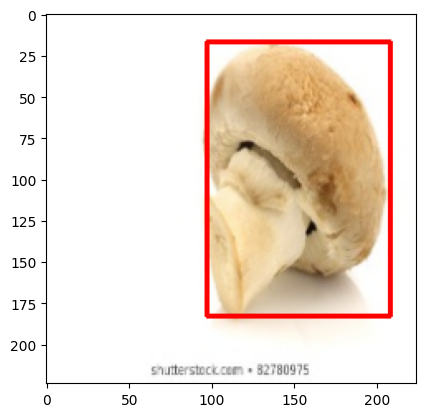

In [42]:
img, bbox, label = trainset[100]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)
print(label)

# Load dataset into batches

In [48]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)

In [49]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [50]:
for images,bboxes,label in trainloader:
  break;


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))
print("label_shape", print(label.shape))

Shape of one batch images : torch.Size([16, 3, 224, 224])
Shape of one batch bboxes : torch.Size([16, 4])
torch.Size([16])
label_shape None


# Create Model

In [51]:
from torch import nn
import timm

In [52]:
class CustomObjLocModel(nn.Module):
    def __init__(self):
        super(CustomObjLocModel, self).__init__()

        # Replace this with your custom convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Replace this with your custom dense layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 56 * 56, 256)
        self.relu3 = nn.ReLU()
        self.fc_bbox = nn.Linear(256, 4)  # Output layer with 4 nodes for bounding box coordinates
        self.fc_class = nn.Linear(256, 3) # jusrt labels



    def forward(self, images, gt_bboxes=None, label=None):
        x = self.conv1(images)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        bboxes = self.fc_bbox(x)
        labels_pred = self.fc_class(x)
        
        if gt_bboxes is not None:
            loss_fn1 = nn.MSELoss()
            loss_bbox = loss_fn1(bboxes, gt_bboxes)
            loss_fn2 = nn.CrossEntropyLoss()
            class_loss = loss_fn2(labels_pred, label)
            # Combine both losses
            total_loss = loss_bbox + class_loss
            return bboxes, labels_pred, total_loss

        return bboxes

In [53]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CustomObjLocModel()
model.to(DEVICE)

CustomObjLocModel(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=401408, out_features=256, bias=True)
  (relu3): ReLU()
  (fc_bbox): Linear(in_features=256, out_features=4, bias=True)
  (fc_class): Linear(in_features=256, out_features=3, bias=True)
)

In [54]:
random_img = torch.rand(1, 3, 224, 224).to(DEVICE)
output_shape = model(random_img).shape

print("Model output shape:", output_shape)


Model output shape: torch.Size([1, 4])


# Create Train and Eval Function

In [55]:
def train_fn(model, dataloader, optimizer):
    total_loss = 0.0
    model.train()  # Dropout ON

    for data in tqdm(dataloader):
        images, gt_bboxes, label = data
        images, gt_bboxes, label = images.to(DEVICE), gt_bboxes.to(DEVICE), label.to(DEVICE)

        bboxes,label, loss = model(images, gt_bboxes, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [56]:
def eval_fn(model, dataloader):
    total_loss = 0.0
    model.eval()  # Dropout OFF

    with torch.no_grad():
        for data in tqdm(dataloader):
            images, gt_bboxes, label = data
            images, gt_bboxes, label = images.to(DEVICE), gt_bboxes.to(DEVICE), label.to(DEVICE)

            bboxes,label, loss = model(images, gt_bboxes, label)
            total_loss += loss.item()

    return total_loss / len(dataloader)

#Training Loop

In [57]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
best_valid_loss = np.Inf

for epoch in range(EPOCHS):
    train_loss = train_fn(model, trainloader, optimizer)
    valid_loss = eval_fn(model, validloader)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        print("WEIGHTS-ARE-SAVED")
        best_valid_loss = valid_loss

    print(f"Epoch: {epoch + 1} | Train Loss: {train_loss} | Valid Loss: {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 1 | Train Loss: 4713.075109863281 | Valid Loss: 1886.0465494791667


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 2 | Train Loss: 1105.3508239746093 | Valid Loss: 858.9534912109375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 3 | Train Loss: 763.9658477783203 | Valid Loss: 1074.1996256510417


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 4 | Train Loss: 739.7759155273437 | Valid Loss: 899.9326782226562


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 5 | Train Loss: 730.5866577148438 | Valid Loss: 771.0948486328125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 6 | Train Loss: 609.4023422241211 | Valid Loss: 623.9992879231771


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 7 | Train Loss: 663.6355224609375 | Valid Loss: 526.948964436849


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 8 | Train Loss: 651.919873046875 | Valid Loss: 700.4351501464844


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 9 | Train Loss: 599.9805572509765 | Valid Loss: 657.6148478190104


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 10 | Train Loss: 569.014013671875 | Valid Loss: 553.9717508951823


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 11 | Train Loss: 568.865966796875 | Valid Loss: 527.9893188476562


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 12 | Train Loss: 549.763671875 | Valid Loss: 690.7415568033854


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 13 | Train Loss: 629.4484069824218 | Valid Loss: 559.8416544596354


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 14 | Train Loss: 639.7469451904296 | Valid Loss: 541.3717142740885


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 15 | Train Loss: 608.6167785644532 | Valid Loss: 624.7315470377604


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 16 | Train Loss: 543.7825988769531 | Valid Loss: 566.0586954752604


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 17 | Train Loss: 606.3686981201172 | Valid Loss: 645.9519653320312


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 18 | Train Loss: 599.5280883789062 | Valid Loss: 560.9513854980469


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 19 | Train Loss: 596.516567993164 | Valid Loss: 505.7970682779948


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 20 | Train Loss: 474.4742370605469 | Valid Loss: 557.7943623860677


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 21 | Train Loss: 581.9107788085937 | Valid Loss: 465.3679606119792


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 22 | Train Loss: 461.4027618408203 | Valid Loss: 648.0912679036459


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 23 | Train Loss: 478.7949584960937 | Valid Loss: 634.9435628255209


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 24 | Train Loss: 517.2516937255859 | Valid Loss: 651.4411214192709


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 25 | Train Loss: 585.1442077636718 | Valid Loss: 434.72874959309894


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 26 | Train Loss: 493.8390197753906 | Valid Loss: 569.1643981933594


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 27 | Train Loss: 446.7988800048828 | Valid Loss: 509.7439473470052


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 28 | Train Loss: 445.3120391845703 | Valid Loss: 369.2529805501302


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 29 | Train Loss: 430.59608154296876 | Valid Loss: 321.87647501627606


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 30 | Train Loss: 430.17864990234375 | Valid Loss: 405.62989298502606


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 31 | Train Loss: 446.7096923828125 | Valid Loss: 609.3520914713541


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 32 | Train Loss: 498.8442840576172 | Valid Loss: 396.86439005533856


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 33 | Train Loss: 423.3960784912109 | Valid Loss: 457.7064921061198


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 34 | Train Loss: 398.58115844726564 | Valid Loss: 389.44175211588544


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 35 | Train Loss: 424.6874237060547 | Valid Loss: 358.8597106933594


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 36 | Train Loss: 476.53712158203126 | Valid Loss: 964.0715738932291


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 37 | Train Loss: 559.4541687011719 | Valid Loss: 598.0614217122396


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 38 | Train Loss: 563.1586929321289 | Valid Loss: 462.9333902994792


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 39 | Train Loss: 474.1738250732422 | Valid Loss: 442.1216125488281


  0%|          | 0/10 [00:00<?, ?it/s]

#Inference

In [104]:
import utils

In [105]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()


# Perform inference
with torch.no_grad():
    image, gt_bbox, label = validset[16]
    image = image.unsqueeze(0).to(DEVICE)
    out_bbox = model(image)
    print(label)
    utils.compare_plots(image, gt_bbox, out_bbox)



OutOfMemoryError: CUDA out of memory. Tried to allocate 392.00 MiB. GPU 0 has a total capacty of 3.81 GiB of which 231.06 MiB is free. Including non-PyTorch memory, this process has 3.58 GiB memory in use. Of the allocated memory 3.21 GiB is allocated by PyTorch, and 280.25 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya